In [102]:
import sunpy
import os,sys, re
import datetime
import numpy as np
from sunpy.map import Map
from astropy.io import fits as pyfits
from astropy import wcs
from astropy.coordinates import EarthLocation, SkyCoord, Angle
import matplotlib.pyplot as plt
import copy
import astropy.units as u
import datetime
%matplotlib inline

In [106]:
#Create the AIA map
#aiafile='/Users/kkozarev/sunpy/data/sample_data/AIA20110319_105400_0171.fits'
aiafile='/Users/kkozarev/CORWAV_DATA/AIA_data/2015/11/04/H0300/AIA20151104_033847_0171.fits'
aiamap = Map(aiafile)

In [107]:
#Load the MWA data
infile='/Volumes/PLUME/MWA_DATA/093-094/1130643536/1130643536_c093-094_f8-14_t033843_XX_d001.fits'

fh = pyfits.open(infile)
data=fh[0].data[0,0,:,:]
fh[0].header['ORIGIN'] = 'CASA 4.7.0-REL (r38335)'
print('Header origin: "{0}"'.format(fh[0].header['ORIGIN']))
header = copy.copy(fh[0].header)
header['ORIGIN'] = 'BLANK'
header.update()
try:
    print(wcs.WCS(header))
except ValueError:
    print(wcs.WCS(header))
    


Header origin: "CASA 4.7.0-REL (r38335)"
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 218.13355931640001  -15.18065681751  118840000.02069999  -5.0  
CRPIX : 513.0  513.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0055555555555559999  0.0055555555555559999  280000.00463769998  1.0  
NAXIS : 1024  1024  1  1


In [108]:
obstime=header['date-obs']
#Let's now get the distance between the Earth and the Sun at the time the photo was taken
dsun = sunpy.coordinates.get_sunearth_distance(obstime)
print dsun

#The size of the Sun in the sky is then
rsun_obs = np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec')
print rsun_obs

#The image plate scale is
plate_scale = [float(header['cdelt1']*3600.),float(header['cdelt2']*3600.)]#*u.arcsec/u.pix
print plate_scale

#We also need the solar rotation angle
obsloc=(float(header['obsgeo-x']),float(header['obsgeo-y']),float(header['obsgeo-z']))
loc = EarthLocation(x=obsloc[0]*u.m,y=obsloc[1]*u.m,z=obsloc[2]*u.m)
fudge_angle = 0.0 * u.deg # update this in case your camera was not perfectly level.
solar_rotation_angle = sunpy.coordinates.get_sun_orientation(loc, obstime) + fudge_angle
print solar_rotation_angle

hgln_obs = sunpy.coordinates.get_sun_L0(obstime)
hglt_obs = sunpy.coordinates.get_sun_B0(obstime)
print("{0} {1}".format(hglt_obs, hgln_obs))


#Calculate the starting coords in 'HPLN-TAN'
sunra=Angle(header['crval1'],u.deg)
sundec=Angle(header['crval2'],u.deg)
sun_ref_coords = SkyCoord(ra=sunra,dec=sundec, 
              distance=dsun,frame='icrs').transform_to(aiamap.coordinate_frame)
#sunc=SkyCoord(ra=(header['crval1']*u.deg).to('rad'),
#              dec=(header['crval2']*u.deg).to('rad'), 
#              distance=dsun.to('au'),frame='icrs').transform_to(aiamap.coordinate_frame)


#Create a WCS object and put info in
w = wcs.WCS(naxis=2)
w.wcs.dateobs = header["DATE-OBS"]
#w.wcs.naxis = [header["NAXIS1"],header["NAXIS2"]]
#w.wcs.cunit = [header['cunit1'],header['cunit2']]
#w.wcs.ctype = [header['ctype1'],header['ctype2']]
w.wcs.crpix = [header['crpix1'],header['crpix2']]
w.wcs.ctype = ['TAN', 'TAN']
w.wcs.cunit = ['arcsec', 'arcsec']
#w.wcs.crval = [sun_ref_coords.Tx.value,sun_ref_coords.Ty.value]
#Assume the image is centered on the Sun!!!
w.wcs.crval = [0.,0.]
#w.wcs.cdelt = [header['cdelt1'],header['cdelt2']]
w.wcs.cdelt =  plate_scale#np.ones(2) * plate_scale

#Convert to a header which will be used to generate the map
mapheader = dict(w.to_header())
mapheader.update({'CROTA2': solar_rotation_angle.to('deg').value})
mapheader.update({'DSUN_OBS': dsun.to('m').value})
mapheader.update({'HGLN_OBS': hgln_obs.to('deg').value})
mapheader.update({'HGLT_OBS': hglt_obs.to('deg').value})
#mapheader.update({'CTYPE1': header['CTYPE1']})
#mapheader.update({'CTYPE2': header['CTYPE2']})
mapheader.update({'CTYPE1': 'HPLN-TAN'})
mapheader.update({'CTYPE2': 'HPLT-TAN'})
mapheader.update({'RSUN': dsun.to('m').value})
mapheader.update({'RSUN_OBS': np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec').value})

mapheader.update({'AUTHOR': header['observer']})
#mapheader.update({'EXPTIME': exposure_time.to('s').value})
mapheader.update({'TELESCOP': header['telescop']})

#Create the MWA map
mwamap = Map(data, mapheader)
#Supposedly de-rotated map
mwamap2 = mwamap.rotate(rmatrix=np.linalg.inv(aiamap.rotation_matrix),
                        recenter=True, order=3, scale=(mwamap.scale[0]/aiamap.scale[0]))

mapheader

0.991890104238 AU
966.796596859 arcsec
[-20.0000000000016, 20.0000000000016]
175d33m30.4524s
4.1076905811 deg 316.654003591 deg


{'AUTHOR': 'tfranzen',
 'CDELT1': -20.000000000002,
 'CDELT2': 20.000000000002,
 'CROTA2': 175.5584589882949,
 'CRPIX1': 513.0,
 'CRPIX2': 513.0,
 'CRVAL1': 0.0,
 'CRVAL2': 0.0,
 'CTYPE1': 'HPLN-TAN',
 'CTYPE2': 'HPLT-TAN',
 'CUNIT1': 'arcsec',
 'CUNIT2': 'arcsec',
 'DATE-OBS': '2015-11-04T03:38:41.250000',
 'DSUN_OBS': 148384647562.41348,
 'HGLN_OBS': 316.65400359099476,
 'HGLT_OBS': 4.1076905811044915,
 'LATPOLE': 90.0,
 'RSUN': 148384647562.41348,
 'RSUN_OBS': 966.7965968586612,
 'TELESCOP': 'MWA',
 'WCSAXES': 2}

In [109]:
print sun_ref_coords.Tx.value, sun_ref_coords.Ty.value

1148.6708323 -442.116241349


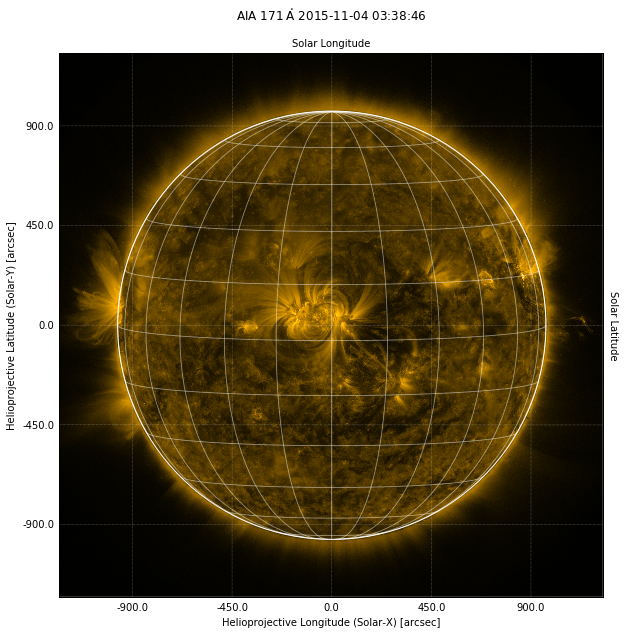

In [110]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=aiamap)
aiamap.plot(axes=ax)
aiamap.draw_grid(axes=ax)
aiamap.draw_limb(axes=ax)
plt.show()

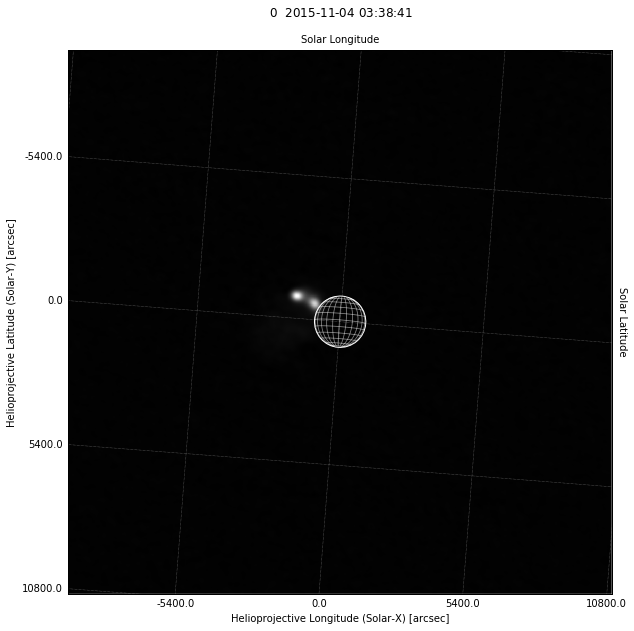

In [111]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=mwamap)
mwamap.plot(axes=ax)
mwamap.draw_grid(axes=ax)
mwamap.draw_limb(axes=ax)
plt.show()

In [103]:
mwamap2 = mwamap.rotate(rmatrix=np.linalg.inv(aiamap.rotation_matrix),
                        recenter=True, order=3, scale=(mwamap.scale[0]/aiamap.scale[0]))

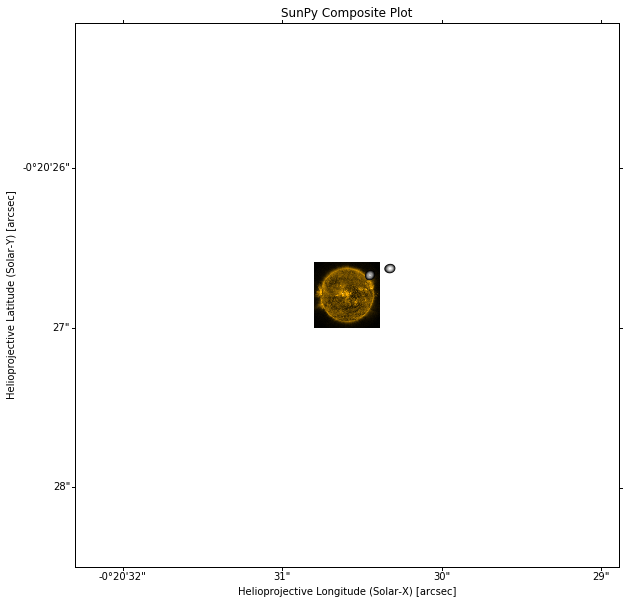

In [104]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=aiamap)

mymaps = Map(aiamap,composite=True)
mymaps.add_map(mwamap)
#mymaps.set_alpha(0,0.5)
mymaps.set_levels(1, [50, 60, 70, 80, 90,99], percent = True)
mymaps.plot()
#mymaps.draw_grid(axes=ax)
#mymaps.draw_limb(axes=ax)

#aiamap.plot(axes=ax)
#aia.draw_limb()
#mwamap.plot()
#plt.show()
#mwamap.plot(axes=ax)
#mwamap.draw_grid(axes=ax)
#mwamap.draw_limb(axes=ax)
plt.show()

In [97]:
print mwamap.bottom_left_coord

print aiamap.bottom_left_coord

<SkyCoord (Helioprojective: obstime=2015-11-04 03:43:45.250000, rsun=695508000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2015-11-04 03:43:45.250000): (lon, lat, radius) in (deg, deg, m)
    (-43.39239019,  4.1073232,   1.48384518e+11)>): (Tx, Ty) in arcsec
    (-8386.17846107,  11780.37094842)>
<SkyCoord (Helioprojective: obstime=2015-11-04 03:43:46.340000, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2015-11-04 03:43:46.340000): (lon, lat, radius) in (deg, deg, m)
    ( 0.,  4.104517,   1.48410675e+11)>): (Tx, Ty) in arcsec
    (-1230.59396233, -1226.79382608)>


In [ ]:
#def remove_non_ascii(text):
#    return unidecode(unicode(text, encoding = "utf-8"))

def mwa_prep(infile):
    data, header = pyfits.getdata(infile, header=True)
    data=data[0,0,:,:]
    w = wcs.WCS(naxis=2)
    w.wcs.naxis1=header["NAXIS1"]
    w.wcs.naxis2=header["NAXIS2"]
    w.wcs.dateobs=header["DATE-OBS"]
    w.wcs.ctype1=header['ctype1']
    w.wcs.ctype2=header['ctype2']
    w.wcs.crpix1=header['crpix1']
    w.wcs.crpix2=header['crpix2']
    w.wcs.crval1=header['crval1']
    w.wcs.crval2=header['crval2']
    w.wcs.cdelt=[header['cdelt1'],header['cdelt2']]